# 事前に学習したモデルと転移学習

CNNの学習には多くの時間がかかり、そのためには多くのデータが必要となります。しかし、その時間の多くは、画像からパターンを抽出するためにネットワークが使用する最適な低レベルフィルタを学習するために費やされます。あるデータセットで学習したニューラルネットワークを、完全な学習プロセスなしに、異なる画像の分類に適応させることができるだろうか？

このアプローチは，あるニューラルネットワークモデルから別のニューラルネットワークモデルに知識を移すことから，**転移学習**と呼ばれています。転移学習では、通常、**ImageNet**のような大規模な画像データセットで学習された、事前に学習されたモデルを使用します。これらのモデルは、すでに一般的な画像からさまざまな特徴をうまく抽出することができ、多くの場合、これらの抽出された特徴の上に分類器を構築するだけで、良い結果を得ることができます。

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import os

from pytorchcv import train, plot_results, display_dataset, train_long, check_image_dir

## Cats vs Dogs データセット

このユニットでは、猫と犬の画像を分類するという現実的な問題を解決します。そのために、[Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats)を使用します。このデータは、[Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765)からダウンロードすることもできます。

このデータセットをダウンロードして、`data`ディレクトリに展開してみましょう（この作業には時間がかかります！）。

In [2]:
if not os.path.exists('data/kagglecatsanddogs_3367a.zip'):
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

In [3]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_3367a.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

残念ながら、データセットの中には破損した画像ファイルがあります。破損したファイルをチェックするために、クイッククリーニングを行う必要があります。このチュートリアルを無駄にしないために、データセットを検証するコードをモジュールに移しました。

In [4]:
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

Corrupt image: data/PetImages/Cat/666.jpg


/Users/shogo/miniforge3/envs/pytorch/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/Users/shogo/miniforge3/envs/pytorch/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/Users/shogo/miniforge3/envs/pytorch/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/Users/shogo/miniforge3/envs/pytorch/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/Users/shogo/miniforge3/envs/pytorch/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 

Corrupt image: data/PetImages/Dog/11702.jpg


次に、画像をPyTorchデータセットに読み込み、テンソルに変換し、正規化を行います。事前に学習したVGGネットワークが期待する範囲に画像を持ってくるために、`std_normalize`変換を適用します。

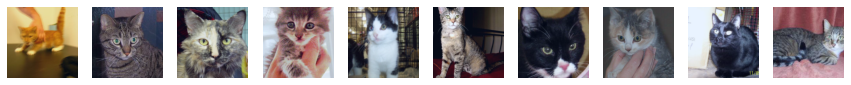

In [5]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        std_normalize])
dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])

display_dataset(dataset)

## 事前に学習したモデル

`Torchvision`モジュールには、様々な学習済みモデルがありますし、インターネットでも多くのモデルを見つけることができます。最も単純なVGG-16モデルをどのようにロードして使用するかを見てみましょう。

In [6]:
vgg = torchvision.models.vgg16(pretrained=True)
sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

tensor(281)


受け取った結果は、`ImageNet`クラスの番号で、これは[ここ](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)で調べることができます。以下のコードを使えば、このクラステーブルを自動的に読み込み、結果を返すことができます。

In [7]:
import json, requests
class_map = json.loads(requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

['n02123045', 'tabby']

また、VGG-16ネットワークのアーキテクチャを見てみましょう。

In [8]:
summary(vgg,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

これまでのレイヤーに加えて、**ドロップアウト**と呼ばれるレイヤーも存在します。これらの層は **正則化** 技術として機能します。正則化とは、学習アルゴリズムに若干の修正を加え、モデルの一般化を図るものです。ドロップアウト層では、学習時に前の層のニューロンの一部（約30％）を破棄し、そのニューロンなしで学習を行います。これにより、最適化プロセスがローカルミニマムから脱却し、異なるニューラルパス間で決定力を分散させることができ、ネットワークの全体的な安定性が向上します。

## GPUによる計算

VGG-16やその他の最新のアーキテクチャのようなディープニューラルネットワークは、実行するのにかなりの計算能力を必要とします。そのため、GPUによるアクセラレーションが可能であれば、それを利用するのが合理的です。そのためには、計算に関わるすべてのテンソルを明示的にGPUに移す必要があります。

通常の方法は、コードの中でGPUの利用可能性をチェックし、GPUまたはCPUのいずれかの計算デバイスを指す`device`変数を定義します。

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()

Doing computations on device = cpu


tensor(282)

## VGGの特徴を抽出する

VGG-16 を使って画像から特徴を抽出するためには、最終的な分類層を持たないモデルが必要です。実際、この「特徴抽出器」は `vgg.features` メソッドを使って得ることができます。

torch.Size([1, 512, 7, 7])


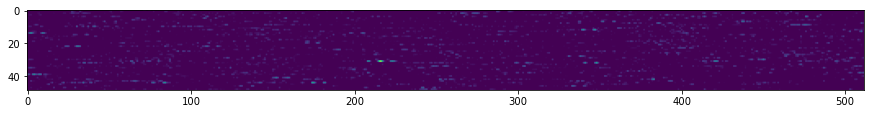

In [10]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15,3))
plt.imshow(res.detach().view(-1,512))
print(res.size())

特徴量テンソルの次元は512×7×7ですが、それを可視化するためには、2次元に整形する必要があります。

では、これらの特徴量を使って、画像を分類できるかどうかを試してみましょう。画像の一部（ここでは800枚）を手動で取り込んで、その特徴ベクトルを事前に計算してみましょう。その結果を `feature_tensor` という1つの大きなテンソルに格納し、ラベルも `label_tensor` に格納します。

In [11]:
bs = 8
dl = torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i>=num:
            break

....................................................................................................

`vgg_dataset` を定義すると、このテンソルからデータを取得し、`random_split` 関数を用いてトレーニングセットとテストセットに分割し、抽出された特徴量の上に小さな 1 層の密な分類器ネットワークをトレーニングすることができます。

In [12]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax()).to(device)

history = train(net,train_loader,test_loader)

Epoch  0, Train acc=0.920, Val acc=0.950, Train loss=0.050, Val loss=0.047
Epoch  1, Train acc=0.976, Val acc=0.960, Train loss=0.022, Val loss=0.026
Epoch  2, Train acc=0.977, Val acc=0.980, Train loss=0.022, Val loss=0.050


/Users/shogo/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch  3, Train acc=0.987, Val acc=0.960, Train loss=0.014, Val loss=0.071
Epoch  4, Train acc=0.993, Val acc=0.970, Train loss=0.013, Val loss=0.056
Epoch  5, Train acc=0.996, Val acc=0.950, Train loss=0.001, Val loss=0.041
Epoch  6, Train acc=0.997, Val acc=0.950, Train loss=0.000, Val loss=0.063
Epoch  7, Train acc=0.996, Val acc=0.980, Train loss=0.006, Val loss=0.038
Epoch  8, Train acc=0.997, Val acc=0.940, Train loss=0.000, Val loss=0.087
Epoch  9, Train acc=0.991, Val acc=0.970, Train loss=0.006, Val loss=0.040


その結果は素晴らしく、ほぼ98%の確率で猫と犬を区別することができました。ただし，手動での特徴抽出には多くの時間がかかるため，この手法は全画像の小さなサブセットでしか試していません．

## 1つのVGGネットワークを用いた転移学習

また、学習時にオリジナルのVGG-16ネットワーク全体を使用することで、特徴量を手動で事前に計算する必要がなくなります。VGG-16のオブジェクト構造を見てみましょう。

In [13]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

ネットワークが含まれていることがわかります。
* feature extractor (`features`), comprised of a number of convolutional and pooling layers
* average pooling layer (`avgpool`)
* final `classifier`, consisting of several dense layers, which turns 25088 input features into 1000 classes (which is the number of classes in ImageNet)
* 複数の畳み込み層とプーリング層で構成される特徴抽出器（`features`）。
* 平均プーリング層 (`avgpool`)
* 25088 個の入力特徴を 1000 個のクラス（ImageNet のクラス数）に変換する、複数の密な層からなる最終的な`分類器`。

データセットを分類するエンド・ツー・エンドのモデルをトレーニングするには、以下のことが必要です。
* **最後の分類器**を、必要な数のクラスを生成するものに置き換えてください。ここでは、25088個の入力と2つの出力ニューロンを持つ1つの「線形」層を使用することができます。
* **畳み込み特徴抽出器の重みを凍結**し、学習されないようにします。最初にこの凍結を行うことをお勧めします。そうしないと、学習されていない分類器層が、元々学習されていた畳み込み特徴抽出器の重みを破壊してしまうからです。重みを凍結するには，すべてのパラメータの `requires_grad` プロパティを `False` に設定します．

In [14]:
vgg.classifier = torch.nn.Linear(25088,2).to(device)

for x in vgg.features.parameters():
    x.requires_grad = False

summary(vgg,(1, 3,244,244))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]    

サマリーからわかるように、このモデルには約1,500万個のパラメータが含まれていますが、そのうち学習可能なものはわずか5万個です（分類層の重み）。これは良いことで、より少ない数の例でより少ない数のパラメータを微調整することができるからです。

それでは，元のデータセットを使ってモデルを学習してみましょう．この処理には長い時間がかかるので，エポックの終了を待たずに中間結果を表示する`train_long`関数を使用します．この学習をGPU対応の計算機で実行することを強くお勧めします。

In [15]:
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.3125, train loss = 0.06964842230081558
Epoch 0, minibatch 90: train acc = 0.9457417582417582, train loss = 0.13203148265461345
Epoch 0, minibatch 180: train acc = 0.955110497237569, train loss = 0.13066007287462772
Epoch 0, minibatch 270: train acc = 0.9614852398523985, train loss = 0.11980636709290676


それなりに正確な猫vs犬の分類器が得られたようです。将来のために保存しておきましょう。

In [ ]:
torch.save(vgg,'data/cats_dogs.pth')

そうすれば、いつでもファイルからモデルを読み込むことができます。次の実験でモデルが破壊されてしまっても、最初からやり直す必要がないので便利だと思います。

In [ ]:
vgg = torch.load('data/cats_dogs.pth')

## 転移学習の微調整

前節では、最終的な分類器層を訓練して、自分たちのデータセットの画像を分類しました。しかし、特徴抽出器の再学習は行わず、モデルがImageNetデータで学習した特徴に依存していました。もし、対象物が通常のImageNetの画像と視覚的に異なる場合、このような特徴の組み合わせでは最良の結果が得られないかもしれません。したがって、畳み込み層の学習も開始することに意味があります。

そのためには、これまで凍結していた畳み込みフィルタのパラメータを解除すればよいのです。

> **注意：** 分類層の重みを安定させるために，最初にパラメータを凍結し，数回のエポックトレーニングを行うことが重要です．パラメーターが凍結されていない状態ですぐにエンドツーエンドのネットワークのトレーニングを開始すると、大きなエラーが発生し、畳み込み層の事前にトレーニングされた重みが破壊される可能性があります。

In [ ]:
for x in vgg.features.parameters():
    x.requires_grad = True

凍結を解除した後、さらに数回のエポックトレーニングを行うことができます。また、事前に学習した重みへの影響を最小限にするために、低い学習率を選択することもできます。しかし、低い学習率であっても、トレーニングの初期には精度が下がり、最終的には固定ウェイトの場合よりも若干高いレベルに達することが予想されます。

> **注意：**これは、ネットワークの多くの層に勾配を伝搬させる必要があるからです。最初のいくつかのミニバッチを見て、その傾向を確認してから、計算を停止するとよいでしょう。

In [ ]:
train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90,lr=0.0001)

Epoch 0, minibatch 0: train acc = 1.0, train loss = 0.0
Epoch 0, minibatch 90: train acc = 0.8990384615384616, train loss = 0.2978392171335744
Epoch 0, minibatch 180: train acc = 0.9060773480662984, train loss = 0.1658294214069514
Epoch 0, minibatch 270: train acc = 0.9102859778597786, train loss = 0.11819224340009514
Epoch 0, minibatch 360: train acc = 0.9191481994459834, train loss = 0.09244130522920814
Epoch 0, minibatch 450: train acc = 0.9261363636363636, train loss = 0.07583886292451236
Epoch 0, minibatch 540: train acc = 0.928373382624769, train loss = 0.06537413817456822
Epoch 0, minibatch 630: train acc = 0.9318541996830428, train loss = 0.057419379426257924
Epoch 0, minibatch 720: train acc = 0.9361130374479889, train loss = 0.05114534460059813
Epoch 0, minibatch 810: train acc = 0.938347718865598, train loss = 0.04657612246737968
Epoch 0, minibatch 900: train acc = 0.9407602663706992, train loss = 0.04258851655712403
Epoch 0, minibatch 990: train acc = 0.9431130171543896, tr

## その他のコンピュータビジョンモデル

VGG-16は、最もシンプルなコンピュータ・ビジョン・アーキテクチャの1つです。`torchvision` パッケージには、さらに多くの学習済みネットワークが用意されています。その中でも最もよく使われるのは、Microsoftが開発した**ResNet**アーキテクチャと、Googleが開発した**Inception**アーキテクチャです。例えば、最も単純なResNet-18モデルのアーキテクチャを調べてみましょう（ResNetは深さの異なるモデルのファミリーで、本当に深いモデルがどのようなものかを見たい場合は、ResNet-151で実験してみることができます）。

In [ ]:
resnet = torchvision.models.resnet18()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ご覧の通り、このモデルには、特徴抽出器と最終分類器（`fc`）という同じ構成要素が含まれています。これにより、これまでVGG-16を用いて転移学習を行ってきたのと全く同じ方法で、このモデルを使用することができます。上のコードで、ベースモデルに異なるResNetモデルを使って、精度がどう変わるか試してみてください。

## バッチの正規化

このネットワークには、さらに別のタイプのレイヤーが含まれています。**バッチ・ノーマライゼーション（Batch Normalization）**です。バッチ・ノーマライゼーションの考え方は、ニューラルネットワークを流れる値を正しい間隔にすることです。通常、ニューラルネットワークは、すべての値が[-1,1]または[0,1]の範囲にあるときに最もよく機能します。これが、入力データを適宜スケール/正規化する理由です。しかし、ディープネットワークの学習中に、値がこの範囲から大きく外れることがあり、学習に問題が生じることがあります。バッチ正規化層は、現在のミニバッチのすべての値の平均値と標準偏差を計算し、それを使って信号を正規化してから、ニューラルネットワーク層に渡します。これにより、ディープネットワークの安定性が大幅に向上します。

## 覚えておくべき重要点

転移学習を利用することで、独自の物体分類タスクのための分類器を素早く構築し、高い精度を得ることができました。しかし、この例は完全に公平ではありません。というのも、オリジナルのVGG-16ネットワークは猫と犬を認識するようにあらかじめ学習されており、ネットワークにすでに存在するパターンのほとんどを再利用しているだけだからです。工場の生産ラインの詳細や、木の葉の違いなど、より特殊なドメイン固有のオブジェクトでは、精度が低くなることが予想されます。

このように、現在取り組んでいる複雑な課題は、より高い計算能力を必要とし、CPUでは容易に解決できないことがわかります。次のユニットでは、より軽量な実装を用いて、同じモデルをより少ない計算資源で学習することを試みますが、その結果、精度はわずかに低下しました。

## 演習問題

1. 転移学習では、1000クラスで事前学習したVGG-16ネットワークを使用しています。ネットワークに登録できるクラス数はいくつですか？

- Any
  > 正解
- 1000
- 2
- less than 1000
